In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare routines

- tridiagonal matrix multiplication

In [2]:
from tdse.matrix_py import mat_vec_mul_tridiag, gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

# Parameter

- may be replaced by input file read

In [3]:
R_in = 200.03
delta_x = 0.2
imag_pot_width = 30.0
delta_t_real = 0.05
t0 = 0.0
imag_prop = False

V_x_func = lambda x: np.zeros_like(x)
# V_x_func = lambda x: - np.exp(-0.01*x*x) * 0.025

# omega_pot = np.sqrt(0.002)
# V_x_func = lambda x: 0.5 * omega_pot*omega_pot * x*x

omega = 0.5
num_cycle = 2
A0 = 2.0
# A_t_func = lambda t: np.zeros_like(t)
def A_t_func_single(t):
    global omega, num_cycle
    _duration = num_cycle * 2.0 * np.pi / omega
    if t > _duration: return 0.0
    return A0 * np.square(np.sin(omega / (2*num_cycle) * t)) * np.sin(omega*t + np.pi/2.0)

A_t_func = np.vectorize(A_t_func_single)

# t_max_in = 10.98
pulse_duration = num_cycle * 2.0 * np.pi / omega
t_max_in = 0.3 * pulse_duration

### Derived parameters

### Check parameters

In [4]:
assert R_in > 0 and delta_x > 0 and imag_pot_width > 0 and delta_t_real > 0

# Construct coordinates arrays

## spatial array

In [5]:
N_x = 2 * int(R_in // delta_x) + 1
N_x_width = N_x // 2
R = delta_x * N_x_width
assert R == (R_in - (R_in % delta_x))  # check consistency
x_arr = np.linspace(-R,R,N_x)
assert np.isclose(x_arr[1] - x_arr[0],delta_x, atol=1e-13, rtol=0)  # check consistency

## temporal array

In [6]:
N_timestep = int( (t_max_in - t0 + delta_t_real) // delta_t_real )
t_max = t0 + delta_t_real * N_timestep
N_timepoint = N_timestep + 1
t_arr = np.linspace(t0, t_max, N_timepoint)
assert np.isclose(t_arr[1] - t_arr[0], delta_t_real, atol=1e-14, rtol=0)  # check consistency

# Construct potential arrays: $V(x)$, $A(t)$

In [7]:
V_x_arr = V_x_func(x_arr)

### Check by plotting

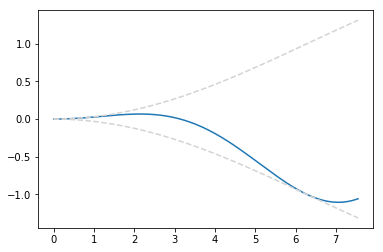

In [8]:
figA, axA = plt.subplots()
axA.plot(t_arr, A_t_func(t_arr))
env_arr = A0 * np.square(np.sin(omega / (2*num_cycle) * t_arr))
axA.plot(t_arr, env_arr, t_arr, -env_arr, color='lightgrey', linestyle='--')

# Set initial state function

In [9]:
sf_shape = (N_x,)
sf_arr_0 = np.empty(sf_shape, dtype=complex)

# sf_arr_0[:] = np.random.rand(*sf_shape) - 0.5
from tdse.analytic import Gaussian1D
sf_arr_0[:] = Gaussian1D(x_arr, t0, k_x=0.0)
# sf_arr_0[:] = Gaussian1D(x_arr, t0, k_x=0.5)

sf_arr = np.empty(sf_shape, dtype=complex)
sf_arr[:] = sf_arr_0.copy()

## Plot

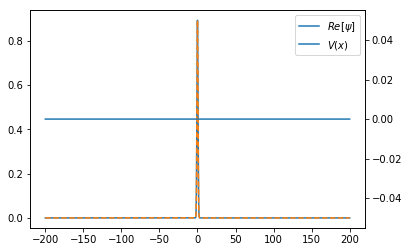

In [10]:
fig_ini, ax_ini = plt.subplots()
l_sf_real, = ax_ini.plot(x_arr, sf_arr_0.real)
l_sf_abs, = ax_ini.plot(x_arr, np.abs(sf_arr_0), '--')

ax_energy = ax_ini.twinx()
l_pot, = ax_energy.plot(x_arr, V_x_arr, '-')

ax_ini.legend((l_sf_real, l_pot),(r'$Re[\psi]$','$V(x)$'))

# Analytical result

In [11]:
sf_arr_ana = np.empty_like(sf_arr_0, dtype=complex)
# sf_arr_ana[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)
# sf_arr_ana = np.zeros_like(sf_arr_0)

# from tdse.analytic import harmonic_oscillator_eigenfunc
# sf_arr_ana[:] = harmonic_oscillator_eigenfunc(x_arr, 0, omega_pot)

In [12]:
sf_arr_ana_gauss = np.empty_like(sf_arr_0, dtype=complex)
sf_arr_ana_gauss[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)
# sf_arr_ana_gauss[:] = Gaussian1D(x_arr, t=t_max, k_x=0.5)

## For volkov state

### Construct k points array

In [13]:
k_max = np.pi / delta_x
delta_k = 2.0 * np.pi / (delta_x * (N_x-1))
k_arr = np.linspace(-k_max,k_max,N_x)
assert np.isclose(k_arr[1] - k_arr[0], delta_k, atol=1e-14, rtol=0)  # check consistency

### Evaluate state function in k-space

In [14]:
sf_k_arr = np.empty((N_x,), dtype=complex)

integrand = np.empty_like(sf_k_arr, dtype=complex)
from tdse.integral import numerical_integral_trapezoidal as int_trapz
for k_idx in range(k_arr.size):
    k = k_arr[k_idx]
    integrand[:] = sf_arr_0 * np.exp(-1.0j * k * x_arr)
    sf_k_arr[k_idx] = 1.0 / np.sqrt(2.0*np.pi) * int_trapz(x_arr, integrand)

In [15]:
def eval_volkov_phase_k_arr(k_arr, t_idx, t_arr, A_t_func):
    _volkov_phase_k_arr = np.empty_like(k_arr, dtype=float)
    if t_idx == 0:
        _volkov_phase_k_arr[:] = 0
        return _volkov_phase_k_arr
    _t_arr_slice = t_arr[:(t_idx+1)]
    _A_t_arr_slice = A_t_func(_t_arr_slice)
    for k_idx in range(k_arr.size):
        k = k_arr[k_idx]
        _volkov_phase_k_arr[k_idx] = int_trapz(_t_arr_slice, 0.5 * (k*k + 2*k*_A_t_arr_slice))
    return _volkov_phase_k_arr

In [16]:
t_idx = int( (t_max - t0 + delta_t_real) // delta_t_real )
volkov_phase_k_arr = eval_volkov_phase_k_arr(k_arr, t_idx, t_arr, A_t_func)

integrand = np.empty(sf_shape, dtype=complex)
for x_idx in range(x_arr.size):
    x = x_arr[x_idx]
    integrand = sf_k_arr * np.exp(1.0j * (k_arr * x - volkov_phase_k_arr))
    sf_arr_ana[x_idx] = 1.0 / np.sqrt(2.0*np.pi) * int_trapz(k_arr, integrand)

## Plot

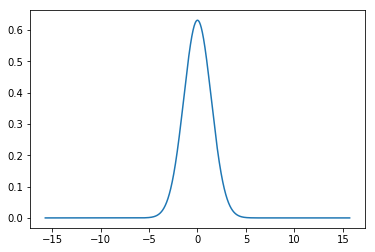

In [17]:
figk, axk = plt.subplots()
axk.plot(k_arr, sf_k_arr.real)
# axa.plot(k_arr, volkov_phase_k_arr.real)

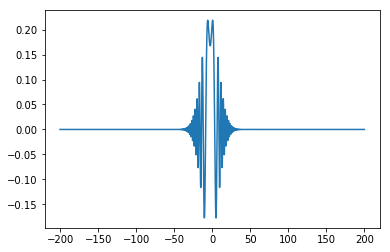

In [18]:
figa, axa = plt.subplots()
axa.plot(x_arr, sf_arr_ana.real)
# axa.plot(k_arr, volkov_phase_k_arr.real)

# Propagation

## Construct tridiagonals

### intermediate matrices

In [19]:
tridiag_shape = (3,N_x)

M2 = np.empty(tridiag_shape, dtype=float)
M2[0,1:], M2[1,:], M2[2,:-1] = 1.0/12.0, 10.0/12.0, 1.0/12.0

D2 = np.empty(tridiag_shape, dtype=float)
D2[0,1:], D2[1,:], D2[2,:-1] = 1.0, -2.0, 1.0
D2 *= 1.0 / (delta_x * delta_x)

M2V = np.empty(tridiag_shape, dtype=float)
M2V[0,1:], M2V[1,:], M2V[2,:-1] = M2[0,1:] * V_x_arr[:-1], M2[1,:] * V_x_arr[:], M2[2,:-1] * V_x_arr[1:]

M1 = np.empty(tridiag_shape, dtype=float)
M1[0,1:], M1[1,:], M1[2,:-1] = 1.0/6.0, 2.0/3.0, 1.0/6.0

D1 = np.empty(tridiag_shape, dtype=float)
D1[0,1:], D1[1,:], D1[2,:-1] = -1.0, 0.0, 1.0
D1 *= 1.0 / (2.0 * delta_x)

### unitary

- [ ] Later, consider putting the imaginary (thus norm-absorbing) potential into the real part of the unitary operator

In [20]:
# U0_half = np.empty(tridiag_shape, dtype=complex)
# U0_half[:] = M2 - 1.0j * delta_t * 0.25 * (-0.5 * D2 + M2V)
# U0_conj_half = np.empty(tridiag_shape, dtype=complex)
# U0_conj_half[:] = M2 + 1.0j * delta_t * 0.25 * (-0.5 * D2 + M2V)

# U0 = np.empty(tridiag_shape, dtype=complex)
# U0[:] = M2 - 1.0j * delta_t * 0.5 * (-0.5 * D2 + M2V)
# U0_conj = np.empty(tridiag_shape, dtype=complex)
# U0_conj[:] = M2 + 1.0j * delta_t * 0.5 * (-0.5 * D2 + M2V)

## Actual propagation

In [21]:
from tdse.integral import normalize_trapezoid
from numbers import Integral

def prop_1d_with_field(start_t_idx, num_timestep, t_arr, delta_t_real, A_t_func, 
                       M1, D1, M2, D2, M2V, sf_arr, x_arr, imag_prop):
    
    ## Check input arguments
    assert isinstance(num_timestep, Integral) and num_timestep > 0

    ## Configure time propagation
    _delta_t = delta_t_real
    if imag_prop: 
        _delta_t *= (-1.0j)
        A_t_func = lambda t: np.zeros_like(t)
    
    ## Allocate memory 
    # for intermediate result
    _sf_arr_mid = np.empty_like(sf_arr, dtype=complex)
    #
    # for time-evolution operator
    _tridiag_shape = (3,x_arr.size)
    _UA = np.empty(_tridiag_shape, dtype=complex)
    _UA_conj = np.empty(_tridiag_shape, dtype=complex)
    _U0_half = np.empty(_tridiag_shape, dtype=complex)
    _U0_conj_half = np.empty(_tridiag_shape, dtype=complex)
    _U0 = np.empty(_tridiag_shape, dtype=complex)
    _U0_conj = np.empty(_tridiag_shape, dtype=complex)

    ## Construct unitary time evolution operators
    _U0_half[:] = M2 - 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
    _U0_conj_half[:] = M2 + 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
    _U0[:] = M2 - 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)
    _U0_conj[:] = M2 + 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)
    
    
    _t_idx = start_t_idx
    _t = 0.5 * (t_arr[_t_idx] + t_arr[_t_idx+1])  # use the middle time point for each timestep
    _A_t = A_t_func(_t)

    _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
    _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

    tridiag_forward(_U0_half, sf_arr, _sf_arr_mid)
    tridiag_backward(_U0_conj_half, sf_arr, _sf_arr_mid)
    tridiag_forward(_UA, sf_arr, _sf_arr_mid)
    tridiag_backward(_UA_conj, sf_arr, _sf_arr_mid)

    for _t_idx in range(start_t_idx+1,start_t_idx+num_timestep):

        if imag_prop: normalize_trapezoid(x_arr, sf_arr)

        _t = 0.5 * (t_arr[_t_idx] + t_arr[_t_idx+1])
        _A_t = A_t_func(_t)

        _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
        _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

        tridiag_forward(_U0, sf_arr, _sf_arr_mid)
        tridiag_backward(_U0_conj, sf_arr, _sf_arr_mid)
        tridiag_forward(_UA, sf_arr, _sf_arr_mid)
        tridiag_backward(_UA_conj, sf_arr, _sf_arr_mid)

    tridiag_forward(_U0_half, sf_arr, _sf_arr_mid)
    tridiag_backward(_U0_conj_half, sf_arr, _sf_arr_mid)

    if imag_prop: normalize_trapezoid(x_arr, sf_arr)

In [22]:
# N_timestep_cur = int(N_timestep * 0.1)

prop_1d_with_field(0, N_timestep, t_arr, delta_t_real, A_t_func, 
                   M1, D1, M2, D2, M2V, sf_arr, x_arr, imag_prop=False)

## Plot

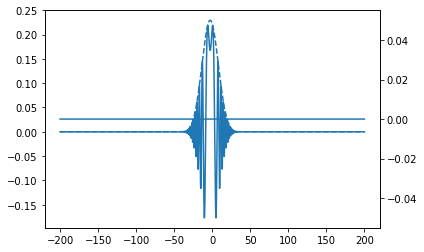

In [23]:
fig_sf, ax_sf = plt.subplots()
l_sf_real, = ax_sf.plot(x_arr, sf_arr.real)
l_sf_abs, = ax_sf.plot(x_arr, np.abs(sf_arr), '--', color=l_sf_real.get_color())

ax_energy = ax_sf.twinx()
l_pot, = ax_energy.plot(x_arr, V_x_arr, '-')

ax_ini.legend((l_sf_real, l_pot),(r'$Re[\psi]$','$V(x)$'))

# Error estimation

In [24]:
err_arr = np.empty(sf_shape, dtype=float)
if imag_prop: err_arr[:] = np.abs(sf_arr) - np.abs(sf_arr_ana)
else: err_arr[:] = np.abs(sf_arr - sf_arr_ana)

# Visualization

In [25]:
from matplotlib import rcParams
rcParams['font.size'] = 15

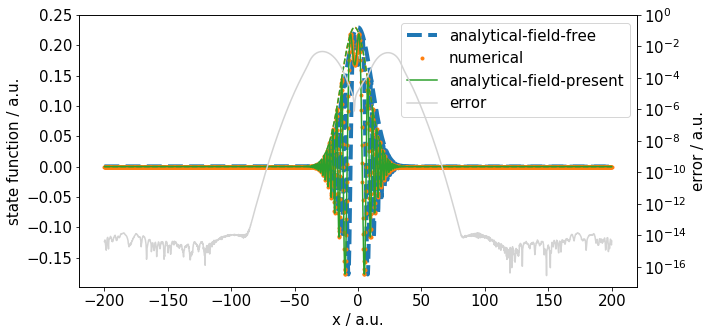

In [26]:
fig, ax = plt.subplots(figsize=(10,5))

l_gauss, = ax.plot(x_arr, sf_arr_ana_gauss.real, '--', linewidth=4)
ax.plot(x_arr, np.abs(sf_arr_ana_gauss), '--', color=l_gauss.get_color(), linewidth=4)

l_num, = ax.plot(x_arr, sf_arr.real,'.')
ax.plot(x_arr, np.abs(sf_arr), '--', color=l_num.get_color())

l_ana, = ax.plot(x_arr, sf_arr_ana.real)
ax.plot(x_arr, np.abs(sf_arr_ana), '--', color=l_ana.get_color())
ax.set_xlabel("x / a.u.")
ax.set_ylabel("state function / a.u.")

ax2 = ax.twinx()
l_error, = ax2.semilogy(x_arr, err_arr, color='lightgrey')
ax2.set_ylim(None,1)
ax2.set_ylabel('error / a.u.')

ax.legend((l_gauss, l_num, l_ana, l_error),('analytical-field-free', 'numerical','analytical-field-present','error'))

In [27]:
ax.set_xlim(-50,50)

(-50, 50)

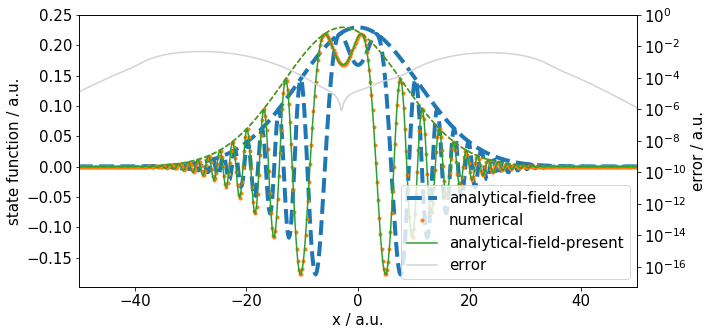

In [28]:
fig

In [29]:
# fig.savefig("comparison-field-present-gaussian-seems-good-showing-agreement-2.png")

In [30]:
from tdse.integral import eval_norm_trapezoid

eval_norm_trapezoid(x_arr, err_arr)

0.00046171679073724883